# XGBoost Classifier

In [5]:
# Data viz
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd

# Machine Learning
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, recall_score, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier


In [2]:
data_train = pd.read_csv("../data/conversion_data_train.csv")
display(data_train.head())

,country,age,new_user,source,total_pages_visited,converted
0,China,22,Yes,Direct,2,0
1,UK,21,Yes,Ads,3,0
2,Germany,20,No,Seo,14,1
3,US,23,Yes,Seo,3,0
4,US,28,Yes,Direct,3,0


## Train dataset

This model will be a Logistic Regression taking into account all columns as a feature. To compensate for the imbalance in the target distribution, we'll give greater weight to class 1.

#### Training and predictions

In [3]:
target = "converted"

X = data_train.drop(target, axis=1)
y = data_train[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [4]:
numerical_columns = X_train.select_dtypes(exclude=["object"]).columns
categorical_columns = X_train.select_dtypes(include="object").columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_columns),
        ("cat", OneHotEncoder(drop="first"), categorical_columns)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [6]:
xgboost = XGBClassifier()

params = {
    "max_depth": [10, 15],
    "min_child_weight": [1, 5, 10],
    "n_estimators": [200]
}

grid_search = GridSearchCV(xgboost, param_grid=params, cv=3, scoring="recall")
sample_weights = compute_sample_weight(class_weight={0: 1, 1: 2}, y=y_train)
grid_search.fit(X_train, y_train, sample_weight=sample_weights)

model = grid_search.best_estimator_

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

#### Performance assessment

In [7]:
scores = cross_val_score(model, X_train, y_train, cv=3)
print("The cross-validated mean score is : ", scores.mean())
print("The standard deviation is : ", scores.std())

The cross-validated mean score is :  0.9854610302902523
The standard deviation is :  0.00038857562995634826


In [8]:
print("f1-score on training set : ", f1_score(y_train, y_train_pred))
print("recall_score on training set : ", recall_score(y_train, y_train_pred))
print()
print("f1-score on test set : ", f1_score(y_test, y_test_pred))
print("recall_score on test set : ", recall_score(y_test, y_test_pred))

f1-score on training set :  0.7912223980188484
recall_score on training set :  0.7830882352941176

f1-score on test set :  0.7526822558459423
recall_score on test set :  0.7450980392156863


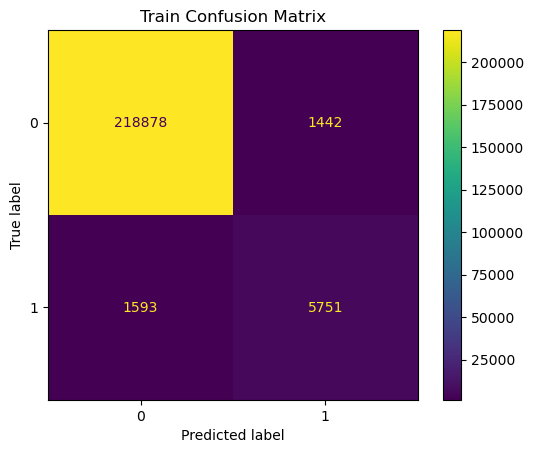

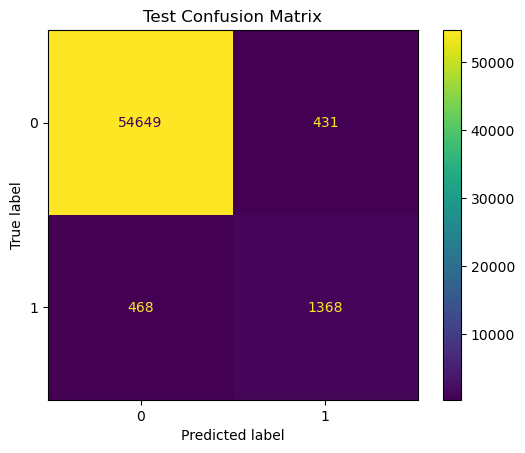

In [9]:
_, ax = plt.subplots()
ax.set(title="Train Confusion Matrix")
ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, ax=ax)
plt.show()

_, ax = plt.subplots()
ax.set(title="Test Confusion Matrix")
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax)
plt.show()

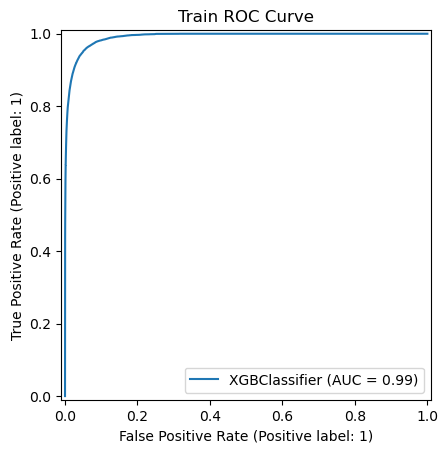

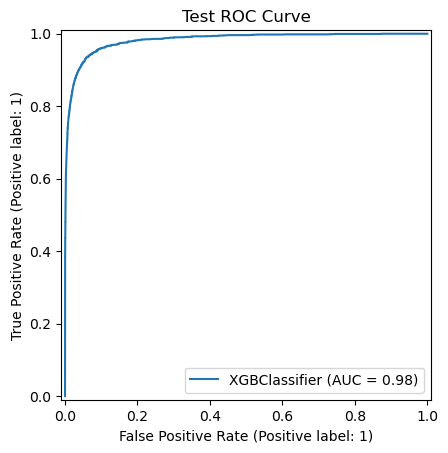

In [10]:
_, ax = plt.subplots()
ax.set(title="Train ROC Curve")
RocCurveDisplay.from_estimator(model, X_train, y_train, ax=ax)
plt.show()

_, ax = plt.subplots()
ax.set(title="Test ROC Curve")
RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax)
plt.show()

The XGBoost model performs very well, especially in the positive class.

The model generalizes correctly, although there is a very slight overlearning.

## Test dataset

### Predictions

In [11]:
data_test = pd.read_csv("../data/conversion_data_test.csv")

x_test = data_test
x_test = preprocessor.transform(x_test)

y_test = pd.read_csv("../data/conversion_data_test_labels.csv")
y_pred = model.predict(x_test)

print("f1-score on set without labels : ", f1_score(y_test, y_pred))
print("recall_score on set without labels : ", recall_score(y_test, y_pred))

f1-score on set without labels :  0.7387208725830441
recall_score on set without labels :  0.7303921568627451


### Performance assessment

In [12]:
scores_df = pd.DataFrame(columns = ["model", "f1", "recall"])
new_rows = [{"model": "xgbc", "f1": f1_score(y_test, y_pred), "recall": recall_score(y_test, y_pred)}]
scores_df = pd.concat([scores_df, pd.DataFrame(new_rows)], ignore_index=True)
scores_df.to_csv("../data/scores.csv", mode="a", header=False, index=False)

/var/folders/yt/qrbwlc0x6fj2rs4chrxkrm_m0000gn/T/ipykernel_31933/2814716046.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores_df = pd.concat([scores_df, pd.DataFrame(new_rows)], ignore_index=True)
